In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

C:\Users\my\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [191]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [130]:
data_crom = pd.read_csv('Crompton_overall.csv')

In [135]:
data_crom.head()

,time_period,overall
0,1/31/2015,812999
1,2/28/2015,1021262
2,3/31/2015,1373382
3,4/30/2015,1115101
4,5/31/2015,1294724


In [136]:
print (data_crom.dtypes)

time_period    object
overall         int64
dtype: object


In [205]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')
data_crom = pd.read_csv('Crompton_overall.csv', parse_dates=['time_period'], index_col='time_period',date_parser=dateparse)

In [241]:
data_crom.index

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='time_period', freq=None)

In [145]:
data_crom.head()

,overall
time_period,
2015-01-31,812999
2015-02-28,1021262
2015-03-31,1373382
2015-04-30,1115101
2015-05-31,1294724


In [146]:
data_crom.index

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='time_period', freq=None)

In [294]:
type(data_crom)

pandas.core.frame.DataFrame

In [206]:
#convert to time series:
ts = data_crom['overall']
ts.head(10)

time_period
2015-01-31     812999
2015-02-28    1021262
2015-03-31    1373382
2015-04-30    1115101
2015-05-31    1294724
2015-06-30    1145392
2015-07-31     829134
2015-08-31     864504
2015-09-30     954934
2015-10-31     821425
Name: overall, dtype: int64

In [165]:
#ts.astype('float64')

In [149]:
from datetime import datetime
ts[datetime(2015,1,31)]

812999

In [166]:
type(ts)

pandas.core.series.Series

In [ ]:
X = ts.values

In [ ]:
X = X.astype('float64')

In [261]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = 30
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_absolute_percentage_error(test, predictions)
	return error

In [262]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MAPE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MAPE=%.3f' % (best_cfg, best_score))

In [263]:
import warnings
warnings.filterwarnings("ignore")
# evaluate parameters
p_values = range(0,10)
d_values = range(0, 3)
q_values = range(0, 10)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MAPE=15.440
ARIMA(0, 0, 1) MAPE=14.005
ARIMA(0, 0, 2) MAPE=14.033
ARIMA(0, 0, 3) MAPE=14.934
ARIMA(0, 1, 0) MAPE=16.795
ARIMA(0, 1, 1) MAPE=17.090
ARIMA(0, 1, 2) MAPE=nan
ARIMA(0, 1, 3) MAPE=nan
ARIMA(0, 1, 6) MAPE=nan
ARIMA(0, 1, 7) MAPE=nan
ARIMA(0, 2, 0) MAPE=29.767
ARIMA(0, 2, 1) MAPE=17.860
ARIMA(1, 0, 0) MAPE=14.789
ARIMA(1, 0, 1) MAPE=15.183
ARIMA(1, 0, 2) MAPE=14.448
ARIMA(1, 1, 0) MAPE=17.042
ARIMA(1, 1, 1) MAPE=17.442
ARIMA(1, 2, 0) MAPE=28.640
ARIMA(1, 2, 1) MAPE=17.798
ARIMA(2, 0, 0) MAPE=14.235
ARIMA(2, 0, 2) MAPE=16.702
ARIMA(2, 1, 0) MAPE=16.995
ARIMA(2, 1, 1) MAPE=16.267
ARIMA(2, 2, 0) MAPE=15.296
ARIMA(2, 2, 1) MAPE=14.798
ARIMA(3, 0, 0) MAPE=13.948
ARIMA(3, 0, 2) MAPE=11.765
ARIMA(3, 1, 0) MAPE=15.018
ARIMA(3, 2, 0) MAPE=15.345
ARIMA(3, 2, 1) MAPE=15.130
ARIMA(4, 0, 0) MAPE=13.042
ARIMA(4, 0, 1) MAPE=13.092
ARIMA(4, 1, 0) MAPE=14.332
ARIMA(4, 2, 0) MAPE=15.025
ARIMA(5, 0, 0) MAPE=13.034
ARIMA(5, 0, 2) MAPE=12.891
ARIMA(5, 1, 0) MAPE=14.914
ARIMA(5, 2, 0

In [269]:
N = series.values

In [270]:
N = N.astype('float64')

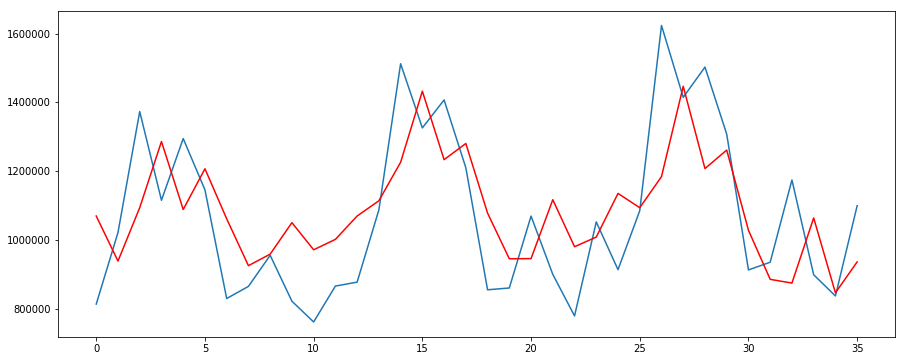

In [271]:
#ARIMA model with p, d, q values obtained from the auto arima function
model = ARIMA(N, order=(3, 0, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(N)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [282]:
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA.head(20)

0     1.069297e+06
1     9.381876e+05
2     1.093717e+06
3     1.286105e+06
4     1.088264e+06
5     1.206743e+06
6     1.061217e+06
7     9.248396e+05
8     9.583237e+05
9     1.050008e+06
10    9.709830e+05
11    1.001281e+06
12    1.069269e+06
13    1.113646e+06
14    1.225648e+06
15    1.432645e+06
16    1.233341e+06
17    1.280390e+06
18    1.077736e+06
19    9.448589e+05
dtype: float64

In [306]:
ts_log = np.log(ts)

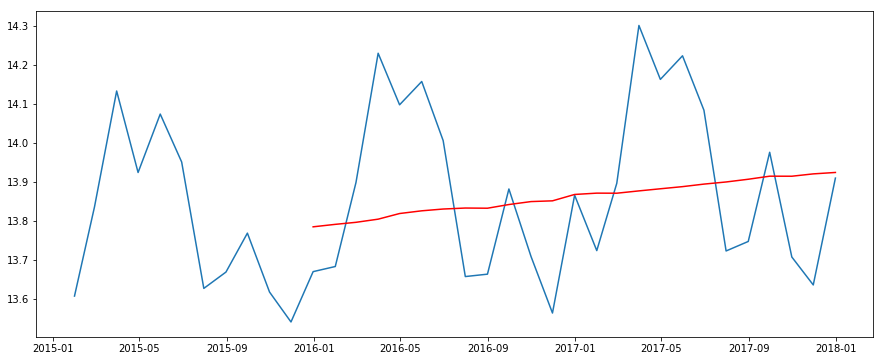

In [310]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

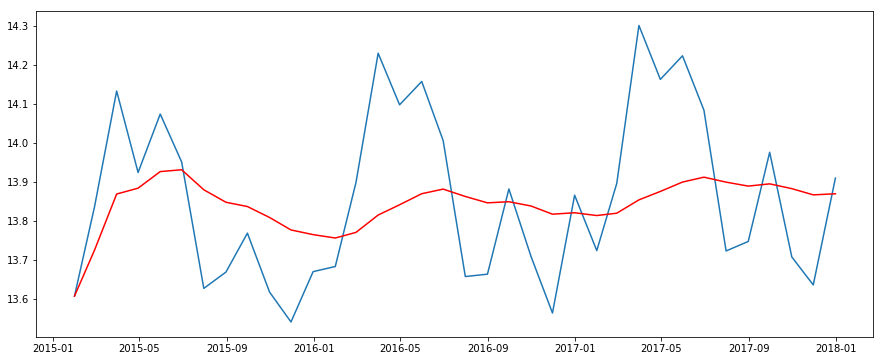

In [313]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

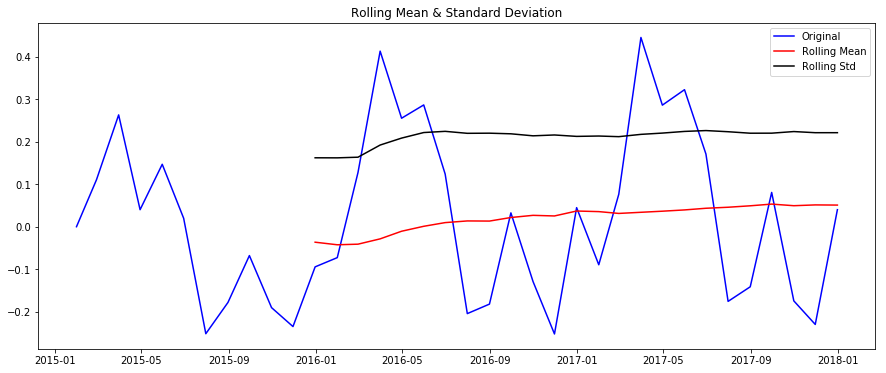

Results of Dickey-Fuller Test:
Test Statistic                 -1.240951
p-value                         0.655736
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [314]:
#Test statistics isn't smaller than the critical vaues here
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

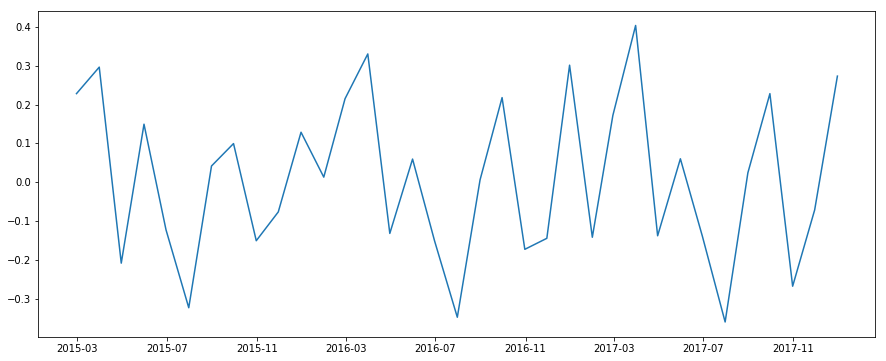

In [315]:
#Differencing

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

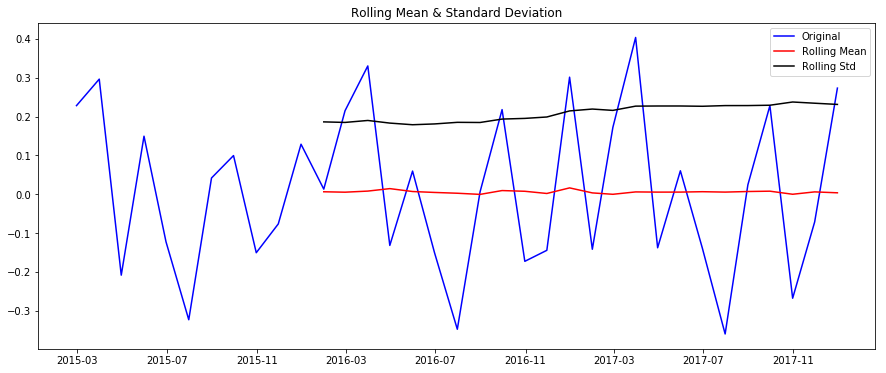

Results of Dickey-Fuller Test:
Test Statistic                -1.068107e+01
p-value                        3.939046e-19
#Lags Used                     1.000000e+01
Number of Observations Used    2.400000e+01
Critical Value (1%)           -3.737709e+00
Critical Value (5%)           -2.992216e+00
Critical Value (10%)          -2.635747e+00
dtype: float64


In [316]:
#Dickey - Fuller test statistics (-1.068107e+01 = -10.68) is lesser than 1% critical value (-3.74). So TS is almost stationary
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

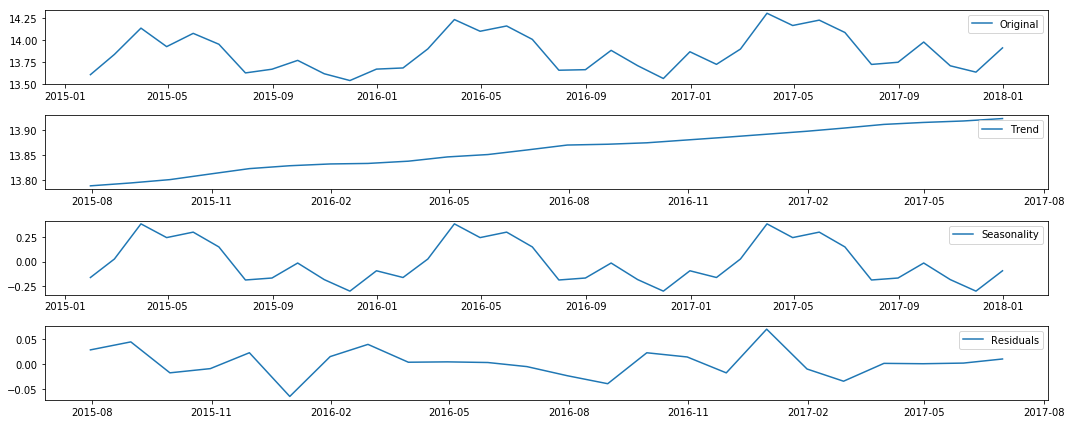

In [317]:
#Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

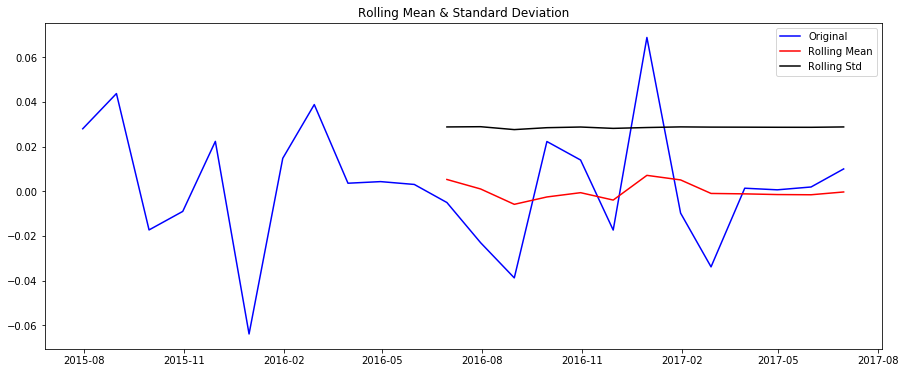

Results of Dickey-Fuller Test:
Test Statistic                 -4.543616
p-value                         0.000164
#Lags Used                      5.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64


In [319]:
#Here also, the Dickey-Fuller test statistics is lesser than the 1% ciritical value. So TS is almost stationary
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [320]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = 30
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_absolute_percentage_error(test, predictions)
	return error

In [321]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MAPE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MAPE=%.3f' % (best_cfg, best_score))

In [324]:
import warnings
warnings.filterwarnings("ignore")
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ts_log_diff.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MAPE=97.015
ARIMA(0, 0, 1) MAPE=94.239
ARIMA(0, 0, 2) MAPE=185.315
ARIMA(0, 1, 0) MAPE=292.998
ARIMA(0, 1, 1) MAPE=118.602
ARIMA(0, 2, 0) MAPE=634.956
ARIMA(0, 2, 1) MAPE=300.190
ARIMA(1, 0, 0) MAPE=93.390
ARIMA(1, 0, 1) MAPE=143.117
ARIMA(1, 1, 0) MAPE=257.377
ARIMA(1, 1, 1) MAPE=117.379
ARIMA(1, 2, 0) MAPE=514.077
ARIMA(1, 2, 1) MAPE=255.767
ARIMA(2, 0, 0) MAPE=125.609
ARIMA(2, 0, 1) MAPE=191.281
ARIMA(2, 1, 0) MAPE=197.041
ARIMA(2, 1, 1) MAPE=175.329
ARIMA(2, 2, 0) MAPE=212.938
ARIMA(2, 2, 1) MAPE=175.798
ARIMA(2, 2, 2) MAPE=172.243
ARIMA(4, 0, 0) MAPE=138.954
ARIMA(4, 1, 0) MAPE=139.401
ARIMA(4, 1, 1) MAPE=130.006
ARIMA(4, 1, 2) MAPE=155.316
ARIMA(4, 2, 0) MAPE=238.236
ARIMA(4, 2, 1) MAPE=142.262
ARIMA(6, 0, 0) MAPE=147.705
ARIMA(6, 1, 0) MAPE=98.748
ARIMA(6, 1, 2) MAPE=158.918
ARIMA(8, 0, 0) MAPE=158.183
ARIMA(8, 1, 0) MAPE=189.702
Best ARIMA(1, 0, 0) MAPE=93.390


In [325]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [326]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

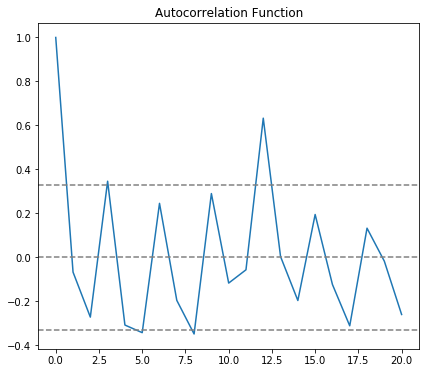

In [327]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

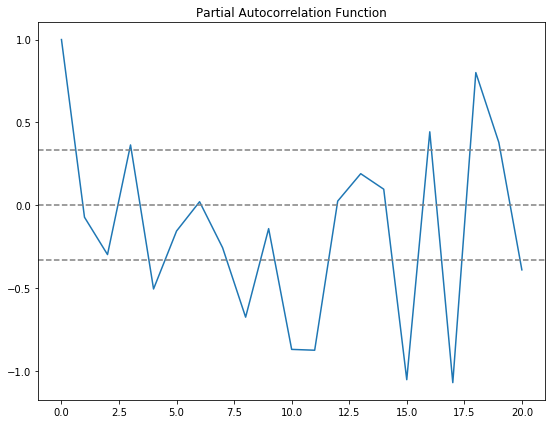

In [328]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5,1,'RSS: 1.1543')

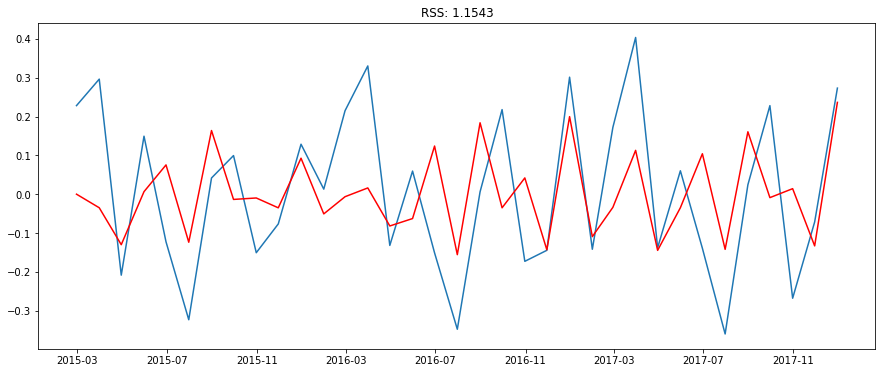

In [331]:
#Combined model
model = ARIMA(ts_log, order=(1, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [333]:
#Let's take the results of the combined model.
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

time_period
2015-02-28    0.000111
2015-03-31   -0.034861
2015-04-30   -0.129904
2015-05-31    0.006567
2015-06-30    0.075423
dtype: float64

In [335]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

time_period
2015-02-28    0.000111
2015-03-31   -0.034751
2015-04-30   -0.164655
2015-05-31   -0.158088
2015-06-30   -0.082665
dtype: float64